In [122]:
import os
import sys
while not os.getcwd().endswith('ml'):
    os.chdir('..')
sys.path.insert(0, os.getcwd())

In [123]:
import math
import copy
import cv2
import pandas as pd
import numpy as np
import random
from shutil import copyfile
from pathlib import Path
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from ml_helpers.image_helpers import display_images
from ml_helpers.common_helpers import display_history_metrics

from sklearn.model_selection import train_test_split
import pickle

from kaggle_problems.rosneft_proppant.workspace.common import bins, bins2mm

from kaggle_problems.rosneft_proppant.workspace.common import TARGET_SHAPE
from kaggle_problems.rosneft_proppant.workspace.common import prop_size2r, bin2low, bin2high
pd.set_option('display.max_columns', None)

In [124]:
bins2mm

{'6': 3.35,
 '7': 2.8,
 '8': 2.36,
 '10': 2.0,
 '12': 1.7,
 '14': 1.4,
 '16': 1.18,
 '18': 1.0,
 '20': 0.85,
 '25': 0.71,
 '30': 0.6,
 '35': 0.5,
 '40': 0.425,
 '45': 0.355,
 '50': 0.3,
 '60': 0.25,
 '70': 0.212,
 '80': 0.18,
 '100': 0.15}

In [125]:
COLORED_IMG_DIR = "kaggle_problems/rosneft_proppant/workspace/data/colored_main_area"
BW_IMG_DIR = "kaggle_problems/rosneft_proppant/workspace/data/bw_main_area"

sieves_names = [6,7,8,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,100]
sieves_names = [str(i) for i in sieves_names]

sive_diam = [3.35,2.8, 2.36, 2, 1.7, 1.4, 1.18, 1, 0.85, 0.71, 0.6, 0.5, 0.425, 0.355, 0.3, 0.25, 0.212, 0.18, 0.15]
sive_diam = np.array(sive_diam)


In [126]:
colored_img = [int(img[:-len(".jpg")]) for img in os.listdir(COLORED_IMG_DIR) if img.endswith('.jpg')]
bw_img = [int(img[:-len(".jpg")]) for img in os.listdir(BW_IMG_DIR) if img.endswith('.jpg')]

In [127]:
print([str(i) + ".jpg" for i in colored_img])

['189.jpg', '77.jpg', '360.jpg', '412.jpg', '599.jpg', '200.jpg', '573.jpg', '598.jpg', '361.jpg', '74.jpg', '439.jpg', '377.jpg', '411.jpg', '766.jpg', '202.jpg', '558.jpg', '612.jpg', '372.jpg', '428.jpg', '206.jpg', '213.jpg', '398.jpg', '159.jpg', '72.jpg', '99.jpg', '588.jpg', '775.jpg', '748.jpg', '760.jpg', '614.jpg', '166.jpg', '9.jpg', '129.jpg', '673.jpg', '317.jpg', '511.jpg', '464.jpg', '699.jpg', '116.jpg', '670.jpg', '102.jpg', '314.jpg', '301.jpg', '473.jpg', '659.jpg', '311.jpg', '265.jpg', '502.jpg', '338.jpg', '648.jpg', '39.jpg', '11.jpg', '299.jpg', '500.jpg', '717.jpg', '501.jpg', '273.jpg', '10.jpg', '134.jpg', '487.jpg', '322.jpg', '336.jpg', '281.jpg', '445.jpg', '479.jpg', '135.jpg', '647.jpg', '309.jpg', '321.jpg', '282.jpg', '533.jpg', '526.jpg', '644.jpg', '122.jpg', '687.jpg', '668.jpg', '318.jpg', '278.jpg', '279.jpg', '331.jpg', '457.jpg', '127.jpg', '133.jpg', '657.jpg', '482.jpg', '290.jpg', '247.jpg', '737.jpg', '508.jpg', '483.jpg', '656.jpg', '19.jpg

In [128]:
train = pd.read_csv("kaggle_problems/rosneft_proppant/workspace/data/labels/train.csv")

In [129]:
bw_train = train[train.ImageId.isin(bw_img)]
#bw_train = bw_train[~bw_train.prop_count.isna()]
bw_train = bw_train[~bw_train['18'].isna()]

In [130]:
bw_train.fraction.unique()

array(['20/40', '16/20'], dtype=object)

In [131]:
#bw_train[bw_train['35'] < 1e-5].describe()
train_20_40 = bw_train[bw_train.fraction=='20/40']
train_20_40[~train_20_40.prop_count.isna()]

,ImageId,6,7,8,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,100,pan,prop_count,fraction
99,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024,0.5404,0.3853,0.0365,0.0132,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,2787.0,20/40


In [141]:
bw_train[bw_train.fraction=='20/40'].describe()

,ImageId,6,7,8,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,100,pan,prop_count
count,88.000000,88.0,88.0,88.0,88.0,88.0,88.0,88.0,88.0,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.0,88.0,88.0,88.0,88.0,1.0
mean,385.681818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035784,0.546131,0.321577,0.081724,0.014023,0.000311,0.000618,0.0,0.0,0.0,0.0,0.0,2787.0
std,220.179370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014203,0.089296,0.085993,0.043184,0.022531,0.001427,0.000896,0.0,0.0,0.0,0.0,0.0,NaN
min,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006100,0.410700,0.183600,0.000000,0.001300,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,2787.0
25%,185.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024000,0.484600,0.240100,0.037600,0.005600,0.000000,0.000300,0.0,0.0,0.0,0.0,0.0,2787.0
50%,411.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039800,0.540400,0.320600,0.079600,0.010900,0.000000,0.000400,0.0,0.0,0.0,0.0,0.0,2787.0
75%,570.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047300,0.622500,0.398100,0.108250,0.013425,0.000000,0.000600,0.0,0.0,0.0,0.0,0.0,2787.0
max,773.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055100,0.712300,0.454900,0.187500,0.130800,0.007800,0.005100,0.0,0.0,0.0,0.0,0.0,2787.0


In [108]:

bins2mm

NameError: name 'bins2mm' is not defined

In [140]:
print([str(i) + '.jpg' for i in bw_train[bw_train.fraction=='20/40'].ImageId])

['1.jpg', '23.jpg', '27.jpg', '45.jpg', '58.jpg', '61.jpg', '64.jpg', '70.jpg', '81.jpg', '83.jpg', '87.jpg', '88.jpg', '94.jpg', '100.jpg', '104.jpg', '130.jpg', '132.jpg', '143.jpg', '163.jpg', '164.jpg', '168.jpg', '170.jpg', '190.jpg', '197.jpg', '219.jpg', '243.jpg', '246.jpg', '257.jpg', '262.jpg', '266.jpg', '268.jpg', '270.jpg', '283.jpg', '286.jpg', '288.jpg', '320.jpg', '326.jpg', '334.jpg', '340.jpg', '366.jpg', '378.jpg', '388.jpg', '399.jpg', '406.jpg', '417.jpg', '420.jpg', '425.jpg', '447.jpg', '454.jpg', '472.jpg', '474.jpg', '477.jpg', '478.jpg', '480.jpg', '481.jpg', '488.jpg', '499.jpg', '504.jpg', '509.jpg', '513.jpg', '517.jpg', '518.jpg', '536.jpg', '546.jpg', '561.jpg', '566.jpg', '583.jpg', '585.jpg', '594.jpg', '596.jpg', '602.jpg', '605.jpg', '629.jpg', '633.jpg', '640.jpg', '650.jpg', '654.jpg', '665.jpg', '672.jpg', '675.jpg', '676.jpg', '702.jpg', '705.jpg', '706.jpg', '725.jpg', '731.jpg', '769.jpg', '773.jpg']


In [135]:
bw_train[bw_train.fraction=='20/40']

,ImageId,6,7,8,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,100,pan,prop_count,fraction
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0525,0.5359,0.2181,0.1875,0.0053,0.0008,0.0000,0.0,0.0,0.0,0.0,0.0,NaN,20/40
22,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0474,0.5946,0.3027,0.0483,0.0056,0.0000,0.0015,0.0,0.0,0.0,0.0,0.0,NaN,20/40
26,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0156,0.6233,0.3219,0.0366,0.0033,0.0000,0.0005,0.0,0.0,0.0,0.0,0.0,NaN,20/40
44,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0145,0.4501,0.4302,0.1033,0.0013,0.0000,0.0007,0.0,0.0,0.0,0.0,0.0,NaN,20/40
57,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0545,0.5662,0.2925,0.0798,0.0070,0.0000,0.0002,0.0,0.0,0.0,0.0,0.0,NaN,20/40
60,61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0372,0.7123,0.2044,0.0347,0.0109,0.0000,0.0006,0.0,0.0,0.0,0.0,0.0,NaN,20/40
63,64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0418,0.4364,0.4064,0.1056,0.0093,0.0000,0.0006,0.0,0.0,0.0,0.0,0.0,NaN,20/40
69,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0415,0.4189,0.4549,0.0675,0.0166,0.0000,0.0007,0.0,0.0,0.0,0.0,0.0,NaN,20/40
80,81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0473,0.4144,0.4531,0.0718,0.0135,0.0000,0.0002,0.0,0.0,0.0,0.0,0.0,NaN,20/40
82,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0145,0.4501,0.4302,0.1033,0.0013,0.0000,0.0007,0.0,0.0,0.0,0.0,0.0,NaN,20/40


In [ ]:
max r = 8 for 20/40

In [103]:
bw_train[bw_train.fraction=='16/20'].describe()

,ImageId,6,7,8,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,100,pan,prop_count
count,527.000000,527.0,527.0,527.0,527.0,527.0,527.0,527.000000,527.000000,527.000000,527.000000,527.000000,527.0,527.000000,527.0,527.0,527.0,527.0,527.0,527.0,527.0,26.000000
mean,402.789374,0.0,0.0,0.0,0.0,0.0,0.0,0.014541,0.450877,0.491128,0.036633,0.006494,0.0,0.000498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2478.346154
std,228.107104,0.0,0.0,0.0,0.0,0.0,0.0,0.007341,0.151848,0.150961,0.019950,0.004295,0.0,0.000391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,351.522510
min,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.004100,0.106600,0.119400,0.005000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1365.000000
25%,208.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.009100,0.347400,0.380100,0.022700,0.003700,0.0,0.000200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2334.000000
50%,404.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.012600,0.448300,0.489700,0.034400,0.006300,0.0,0.000400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2492.000000
75%,597.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.017800,0.549200,0.590800,0.045000,0.007900,0.0,0.000700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2676.750000
max,790.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.041200,0.844800,0.825500,0.111700,0.026200,0.0,0.001500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3029.000000


In [84]:
print(bin2low['18'], bin2high['18'])
print(bin2low['35'], bin2high['35'])

10 11
5 5


In [58]:
colored_train = train[train.ImageId.isin(colored_img)]
#colored_train = colored_train[~colored_train.prop_count.isna()]
colored_train = colored_train[~colored_train['18'].isna()]
colored_train

,ImageId,6,7,8,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,100,pan,prop_count,fraction
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.004757,0.006541,0.083647,0.425173,0.254906,0.0,0.192666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.004377,0.006964,0.063868,0.392161,0.257859,0.0,0.221051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.005179,0.007769,0.089641,0.449004,0.256574,0.0,0.172709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
6,7,0.0,0.0,0.0,0.0,0.0,0.0,0.006147,0.008328,0.081896,0.436050,0.251041,0.0,0.187983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
8,9,0.0,0.0,0.0,0.0,0.0,0.0,0.002591,0.007375,0.054216,0.323699,0.254734,0.0,0.256727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.005529,0.007306,0.073262,0.418839,0.249210,0.0,0.201619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
10,11,0.0,0.0,0.0,0.0,0.0,0.0,0.002792,0.004985,0.068195,0.412562,0.263011,0.0,0.209571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
18,19,0.0,0.0,0.0,0.0,0.0,0.0,0.005793,0.008190,0.078106,0.446864,0.254095,0.0,0.179784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
38,39,0.0,0.0,0.0,0.0,0.0,0.0,0.004594,0.005993,0.084698,0.468837,0.248702,0.0,0.167199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
39,40,0.0,0.0,0.0,0.0,0.0,0.0,0.004187,0.006380,0.076954,0.400718,0.249801,0.0,0.211523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab


In [59]:
colored_train[colored_train.fraction == '16/20'].mean()

ImageId        341.666667
6                0.000000
7                0.000000
8                0.000000
10               0.000000
12               0.000000
14               0.000000
16               0.008445
18               0.345696
20               0.608227
25               0.035619
30               0.001163
35               0.000000
40               0.000142
45               0.000000
50               0.000000
60               0.000000
70               0.000000
80               0.000000
100              0.000000
pan              0.000000
prop_count    2378.500000
dtype: float64

In [60]:
print([str(i) + '.jpg' for i in colored_train[colored_train.fraction != '16/20'].ImageId])

['2.jpg', '3.jpg', '5.jpg', '7.jpg', '9.jpg', '10.jpg', '11.jpg', '19.jpg', '39.jpg', '40.jpg', '57.jpg', '74.jpg', '77.jpg', '79.jpg', '92.jpg', '99.jpg', '102.jpg', '116.jpg', '122.jpg', '129.jpg', '133.jpg', '134.jpg', '135.jpg', '141.jpg', '145.jpg', '155.jpg', '157.jpg', '159.jpg', '166.jpg', '178.jpg', '189.jpg', '196.jpg', '200.jpg', '202.jpg', '206.jpg', '208.jpg', '220.jpg', '223.jpg', '224.jpg', '233.jpg', '247.jpg', '265.jpg', '273.jpg', '278.jpg', '279.jpg', '282.jpg', '290.jpg', '299.jpg', '301.jpg', '309.jpg', '311.jpg', '314.jpg', '317.jpg', '318.jpg', '321.jpg', '322.jpg', '331.jpg', '336.jpg', '338.jpg', '343.jpg', '347.jpg', '360.jpg', '361.jpg', '372.jpg', '390.jpg', '398.jpg', '411.jpg', '412.jpg', '422.jpg', '428.jpg', '430.jpg', '439.jpg', '445.jpg', '457.jpg', '473.jpg', '479.jpg', '482.jpg', '483.jpg', '487.jpg', '500.jpg', '501.jpg', '502.jpg', '508.jpg', '511.jpg', '526.jpg', '533.jpg', '540.jpg', '555.jpg', '558.jpg', '568.jpg', '573.jpg', '588.jpg', '590.jpg

In [61]:
colored_train.fraction

1      20/40_pdcpd_bash_lab
2      20/40_pdcpd_bash_lab
4      20/40_pdcpd_bash_lab
6      20/40_pdcpd_bash_lab
8      20/40_pdcpd_bash_lab
9      20/40_pdcpd_bash_lab
10     20/40_pdcpd_bash_lab
18     20/40_pdcpd_bash_lab
38     20/40_pdcpd_bash_lab
39     20/40_pdcpd_bash_lab
50                    16/20
52                    16/20
56     20/40_pdcpd_bash_lab
71                    16/20
73     20/40_pdcpd_bash_lab
76     20/40_pdcpd_bash_lab
78     20/40_pdcpd_bash_lab
91     20/40_pdcpd_bash_lab
95                    16/20
98     20/40_pdcpd_bash_lab
101    20/40_pdcpd_bash_lab
115    20/40_pdcpd_bash_lab
121    20/40_pdcpd_bash_lab
126                   16/20
128    20/40_pdcpd_bash_lab
132    20/40_pdcpd_bash_lab
133    20/40_pdcpd_bash_lab
134    20/40_pdcpd_bash_lab
140    20/40_pdcpd_bash_lab
144    20/40_pdcpd_bash_lab
               ...         
597    20/40_pdcpd_bash_lab
598    20/40_pdcpd_bash_lab
611    20/40_pdcpd_bash_lab
613    20/40_pdcpd_bash_lab
617    20/40_pdcpd_b

In [62]:
colored_train[colored_train.fraction != '16/20']

,ImageId,6,7,8,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,100,pan,prop_count,fraction
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.004757,0.006541,0.083647,0.425173,0.254906,0.0,0.192666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.004377,0.006964,0.063868,0.392161,0.257859,0.0,0.221051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.005179,0.007769,0.089641,0.449004,0.256574,0.0,0.172709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
6,7,0.0,0.0,0.0,0.0,0.0,0.0,0.006147,0.008328,0.081896,0.436050,0.251041,0.0,0.187983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
8,9,0.0,0.0,0.0,0.0,0.0,0.0,0.002591,0.007375,0.054216,0.323699,0.254734,0.0,0.256727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.005529,0.007306,0.073262,0.418839,0.249210,0.0,0.201619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
10,11,0.0,0.0,0.0,0.0,0.0,0.0,0.002792,0.004985,0.068195,0.412562,0.263011,0.0,0.209571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
18,19,0.0,0.0,0.0,0.0,0.0,0.0,0.005793,0.008190,0.078106,0.446864,0.254095,0.0,0.179784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
38,39,0.0,0.0,0.0,0.0,0.0,0.0,0.004594,0.005993,0.084698,0.468837,0.248702,0.0,0.167199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab
39,40,0.0,0.0,0.0,0.0,0.0,0.0,0.004187,0.006380,0.076954,0.400718,0.249801,0.0,0.211523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,20/40_pdcpd_bash_lab


In [70]:
print(colored_train[colored_train.fraction != '16/20'].mean())
print(colored_train[colored_train.fraction != '16/20'].std())

ImageId        370.126050
6                0.000000
7                0.000000
8                0.000000
10               0.000000
12               0.000000
14               0.000000
16               0.004605
18               0.007023
20               0.077243
25               0.412786
30               0.253526
35               0.000000
40               0.200304
45               0.000000
50               0.000000
60               0.000000
70               0.000000
80               0.000000
100              0.000000
pan              0.000000
prop_count    2570.000000
dtype: float64
ImageId       224.819006
6               0.000000
7               0.000000
8               0.000000
10              0.000000
12              0.000000
14              0.000000
16              0.001335
18              0.001203
20              0.014613
25              0.050904
30              0.007153
35              0.000000
40              0.034531
45              0.000000
50              0.000000
60           

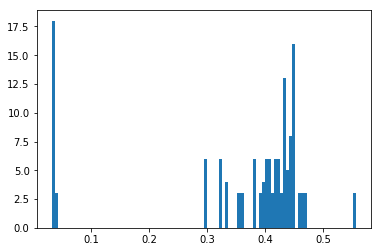

In [195]:
plt.hist(colored_train['25'], bins=100)
plt.show()

In [ ]:
colored_train['25'] > 0.3

## BW

In [172]:
bw_train = train[train.ImageId.isin(bw_img)]
bw_train = bw_train[~bw_train.prop_count.isna()]
bw_train = bw_train[~bw_train['18'].isna()]

In [173]:
def get_bw_prop_count(img, bins):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, threshed = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    #splt.imshow(threshed, cmap='gray')
    s = np.sum(threshed == 255)
    pred_s = 0
    
    for b, diam in zip(sieves_names, sive_diam):
        persent = float(bins[b])
        if persent > 1e-5:
            r = (bin2low[b] + bin2high[b]) / 2
            #print(persent, r)
            pred_s += (r ** 2) * math.pi * persent
    
    return s / pred_s

In [174]:
diff = []
for img_number in bw_train.ImageId:
    img = cv2.imread("{}/{}.jpg".format(BW_IMG_DIR, img_number))
    bins = bw_train[bw_train['ImageId'].isin([img_number])]
    
    real_prop_count = float(bins['prop_count'])
    bins = bins[sieves_names]
    
    pred_prop_count = get_bw_prop_count(img, bins)
    diff.append(real_prop_count - pred_prop_count)

## COLORED

In [186]:
mean_value = {
    "16":               0.005181,
    "18":               0.057824,
    "20":               0.156891,
    "25":               0.356211,
    "30":               0.215671,
    "40":               0.170280,
}

BINS_NAME = ['16', '18', '20', '25', '30', '40']
BINS_SIZE = [1.18, 1, 0.85, 0.71, 0.6, 0.5]


def get_colored_prop_count(img, bins):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    #splt.imshow(threshed, cmap='gray')
    pred_s = 0
    
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    s = np.sum(hsv_img[:, :, 1] > 170)
#     plt.imshow(hsv_img)
    
    for b, diam in zip(BINS_NAME, BINS_SIZE):
        persent = float(bins[b])
        if persent > 1e-5:
            r = (bin2low[b] + bin2high[b]) / 2
            #print(persent, r)
            pred_s += (r ** 2) * math.pi * persent
    
    return s / pred_s

In [187]:
diff = []
for img_number in colored_train.ImageId:
    img = cv2.imread("{}/{}.jpg".format(COLORED_IMG_DIR, img_number))
    bins = colored_train[colored_train['ImageId'].isin([img_number])]
    
    real_prop_count = float(bins['prop_count'])
    bins = bins[sieves_names]
    
    pred_prop_count = get_colored_prop_count(img, mean_value)
    diff.append(real_prop_count - pred_prop_count)
    print(img_number, pred_prop_count, real_prop_count)
    
    

53 3558.142191939619 2102.0
265 2297.932292700741 2570.0
382 4939.961147560064 2655.0


53


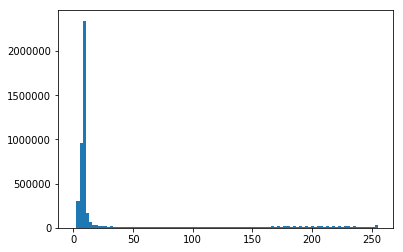

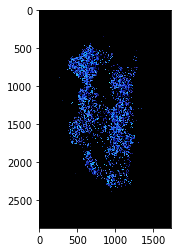

In [177]:
for img_number in colored_train.ImageId:
    print(img_number)
    img = cv2.imread("{}/{}.jpg".format(COLORED_IMG_DIR, img_number))
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#     plt.imshow(hsv_img)
    
    img[np.where(hsv_img[:, :, 1] < 170)] = 0
    
    plt.hist(hsv_img[:, :, 1].reshape(hsv_img.shape[0] * hsv_img.shape[1]), bins=100)
    plt.show()
    
    plt.imshow(img)
    cv2.imwrite("kaggle_problems/rosneft_proppant/workspace/data/tmp.jpg", img)
    break